#### Lab 4 - One Class SVM

In this lab, we will use anomaly detection algorithms like OC-SVM and DeepSVDD.

### 1. OC-SVM, SVDD main ideas

$$
\begin{align}
\min_{w, \xi \in \mathbb{R}^m, \rho \in \mathbb{R}} = \frac{1}{2} \|w\|^2 + \frac{1}{m \nu}\sum_{i=1}^m \xi - \rho \\
s.t. \langle w, x_i \rangle \geq \rho - \xi_i,  \xi_i \geq 0 \quad \forall i \in [m]
\end{align}
$$

Main parameters:
* kernel used
* $\nu$ - upper bound on the fraction of outliers and lower bound on the fraction of SV's.

**SVDD**
$$
\begin{align}
\min_{c, R \ge 0, \xi \in \mathbb{R}^m} R^2 + C \sum_{i=1}^m \xi_i \\
s.t. \|c - x_i\| \le R^2 + \xi_i, \quad \xi_i \geq 0 \quad \forall i \in [m]
\end{align}
$$

**Deep SVDD**
$$
\min_{w} \frac{1}{m} \sum_{i=1}^m \| \phi(x_i; w) - c \|^2 + \frac{\lambda}{2} \sum_{l=1}^L \| W^l \|_F^2
$$

* $L$ - number of hidden layers
* $W^l$ - weights of layer $l$
* $c$ - the center of the hypersphere

A few methods that will be useful to you throughout this lab:

**generate_data()** is used to create sythetic datasets where normal samples are generated using multivariate Gaussian distribution while outliers are generated by uniform distribution; it's parameters include:
- number of training/testing points: `n_train`, `n_test`
- number of features: `n_features`
- proportion of outliers: contamination
- range of values: offset

**sklearn.model_selection.train_test_split()** splits dataset into random train and test subsets and include parameters:
- input data: *arrays,
- test data size and train data size: `test_size=None`, `train_size=None`
- random_state = None
- shuffle = True
- stratify = None, used to split in a stratified fashion.

**sklearn.io.loadmat()** loads data from MATLAB file and includes the folowing parameters:
- file_name
- dictionary in which to insert matfile variables: `mdict=None`
- appendmat=True, to append the .mat extension to the given filename if not already present.

**numpy.quantile** computes the q-th quantile of the data along the specified axis (the value below which the specified percentage of data falls); its parameters include:
- input array: a
- probability or sequence of probabilities of the quantiles to compute; values must be between 0 and 1 inclusive: q

**numpy.random.uniform()** draws samples from a uniform distribution; its parameters include:
- lower boundary and uppper boundary of the output interval: low, high
- output shape: size

### 2. Exercises

#### 2.1 Ex. 1

1. In the first exercise, you will use **generate_data()** function from **pyod.utils.data** module to generate a 3-dimensional dataset with 300 training samples and 200 test samples, using a contamination rate of $0.15$.

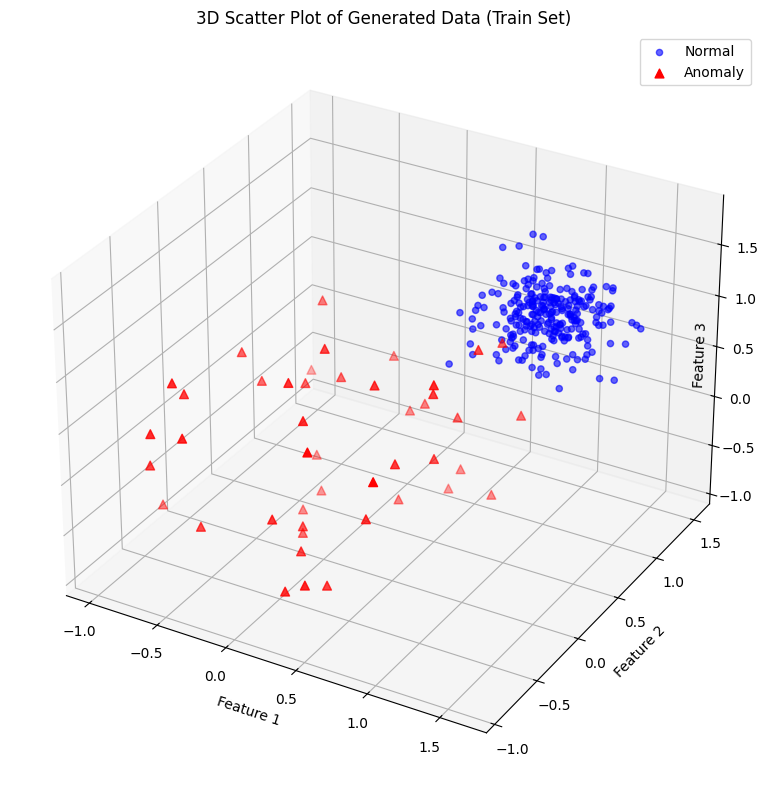

In [2]:
import matplotlib.pyplot as plt
import pyod.utils.data

from mpl_toolkits.mplot3d import Axes3D  

X_train, X_test, y_train, y_test = pyod.utils.data.generate_data(
    n_train=300, 
    n_test=200,
    n_features=3, 
    contamination=0.15, 
    random_state=34
)

def plot_3d_subplot(ax, X, y, title):
    """Helper function to plot 3D data with specific colors for inliers/outliers"""

    # Separate data based on labels (0 = Inlier, 1 = Outlier)
    inliers = X[y == 0]
    outliers = X[y == 1]
    
    # Plot Inliers (Blue)
    ax.scatter(inliers[:, 0], inliers[:, 1], inliers[:, 2], 
               c='blue', label='Normal', s=20, alpha=0.6)
    
    # Plot Outliers (Red)
    ax.scatter(outliers[:, 0], outliers[:, 1], outliers[:, 2], 
               c='red', label='Anomaly', s=40, marker='^')
    
    ax.set_title(title)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Feature 3')
    ax.legend()

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
plot_3d_subplot(ax, X_train, y_train, "3D Scatter Plot of Generated Data (Train Set)")
ax.set_zlabel('Feature 3', labelpad=-28, fontsize=10)
plt.tight_layout()

plt.show()

2. You will fit an **OCSVM** model (from **pyod.models.ocsvm**) using the training data and then you will predict the labels of test data. Use linear kernel and the contamination rate specified above. Compute the balanced accuracy and the ROC AUC for the test data.

In [3]:
import pyod.models.ocsvm
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, confusion_matrix

ocsvm = pyod.models.ocsvm.OCSVM(kernel='linear', contamination=0.15)
ocsvm.fit(X_train)

y_test_pred = ocsvm.predict(X_test)
y_test_scores = ocsvm.decision_function(X_test)

bacc = balanced_accuracy_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_scores)
conf_matrix = confusion_matrix(y_test, y_test_pred)

print(f"Balanced Accuracy: {bacc:.4f}")
print(f"ROC AUC:          {roc_auc:.4f}")

print("\nConfusion Matrix:")
print(conf_matrix)
print("(Row 0: Actual Normal, Row 1: Actual Outliers)")

Balanced Accuracy: 0.9804
ROC AUC:          0.9988

Confusion Matrix:
[[169   1]
 [  1  29]]
(Row 0: Actual Normal, Row 1: Actual Outliers)


3. Create 4 $3D$ subplots where you will plot the test and training data (using different color for inliers and outliers) for both the ground thuth and the preddicted labels.

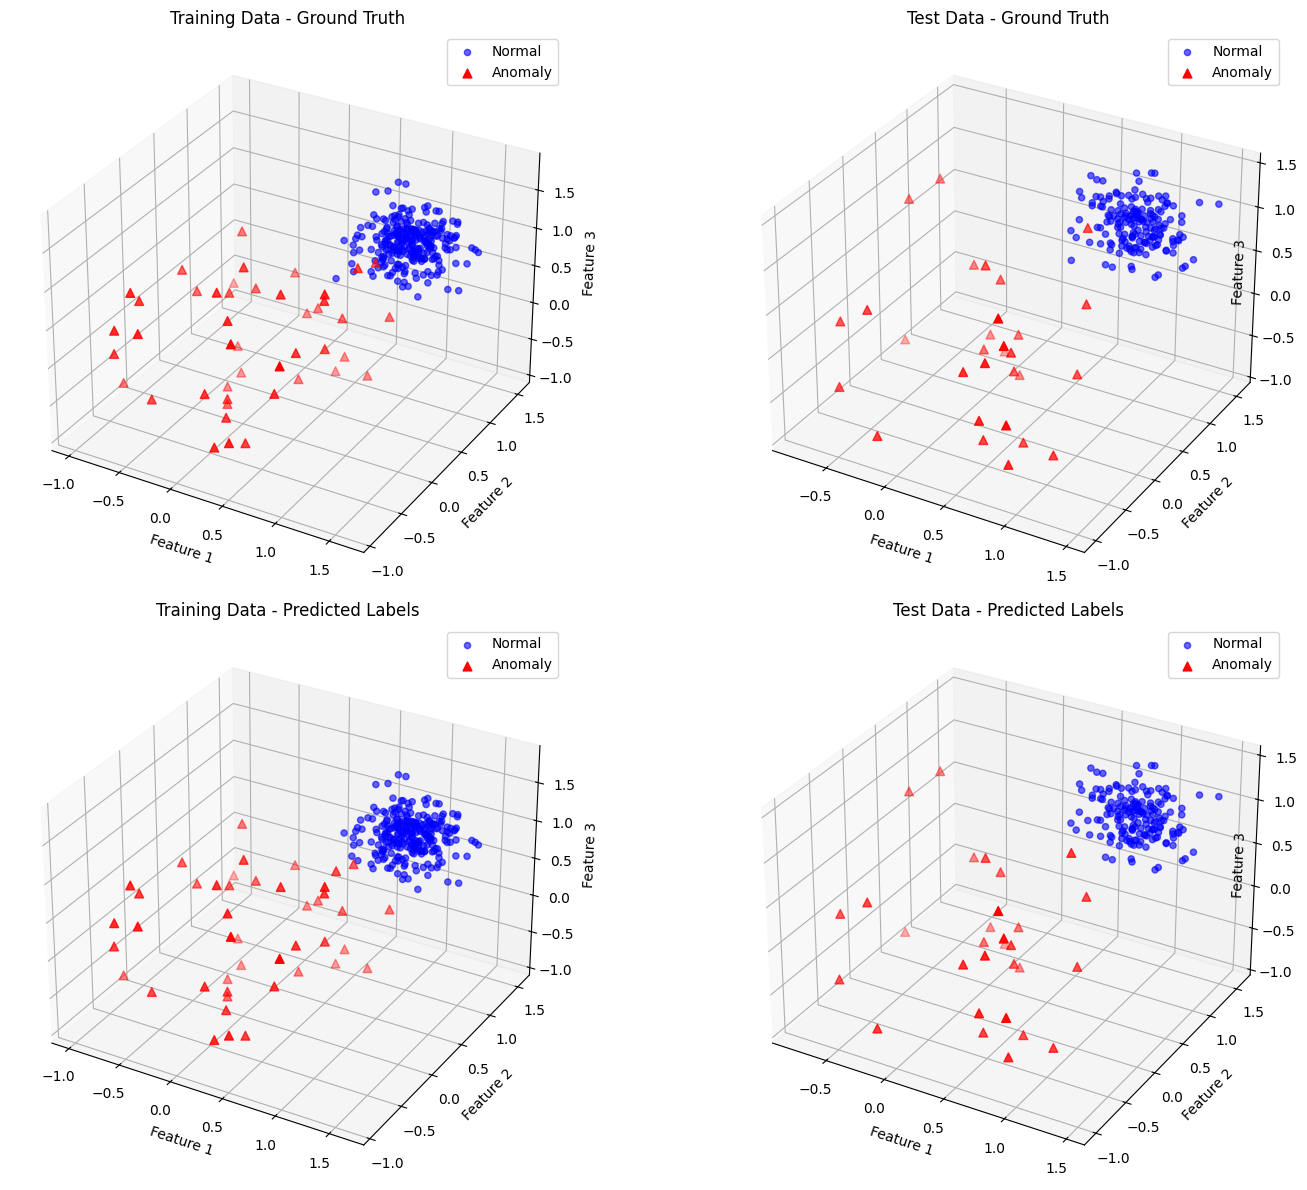

In [4]:
from mpl_toolkits.mplot3d import Axes3D

# Create 4 subplots
fig = plt.figure(figsize=(16, 12))


# First subplot: Training data - Ground Truth
ax1 = fig.add_subplot(221, projection='3d')
plot_3d_subplot(ax1, X_train, y_train, "Training Data - Ground Truth")

# Second subplot: Test data - Ground Truth
ax2 = fig.add_subplot(222, projection='3d')
plot_3d_subplot(ax2, X_test, y_test, "Test Data - Ground Truth")
ax2.set_zlabel('Feature 3', labelpad=-28, fontsize=10)

# Third subplot: Training data - Predicted Labels
ax3 = fig.add_subplot(223, projection='3d')
plot_3d_subplot(ax3, X_train, ocsvm.labels_, "Training Data - Predicted Labels")

# Fourth subplot: Test data - Predicted Labels
ax4 = fig.add_subplot(224, projection='3d')
plot_3d_subplot(ax4, X_test, y_test_pred, "Test Data - Predicted Labels")
ax4.set_zlabel('Feature 3', labelpad=-28, fontsize=10)

plt.tight_layout()
plt.show()

4. Observe how the predicted labels change when you use an RBF kernel.

Balanced Accuracy (RBF): 0.9608
ROC AUC (RBF):          0.9790

Confusion Matrix (RBF):
[[168   2]
 [  2  28]]


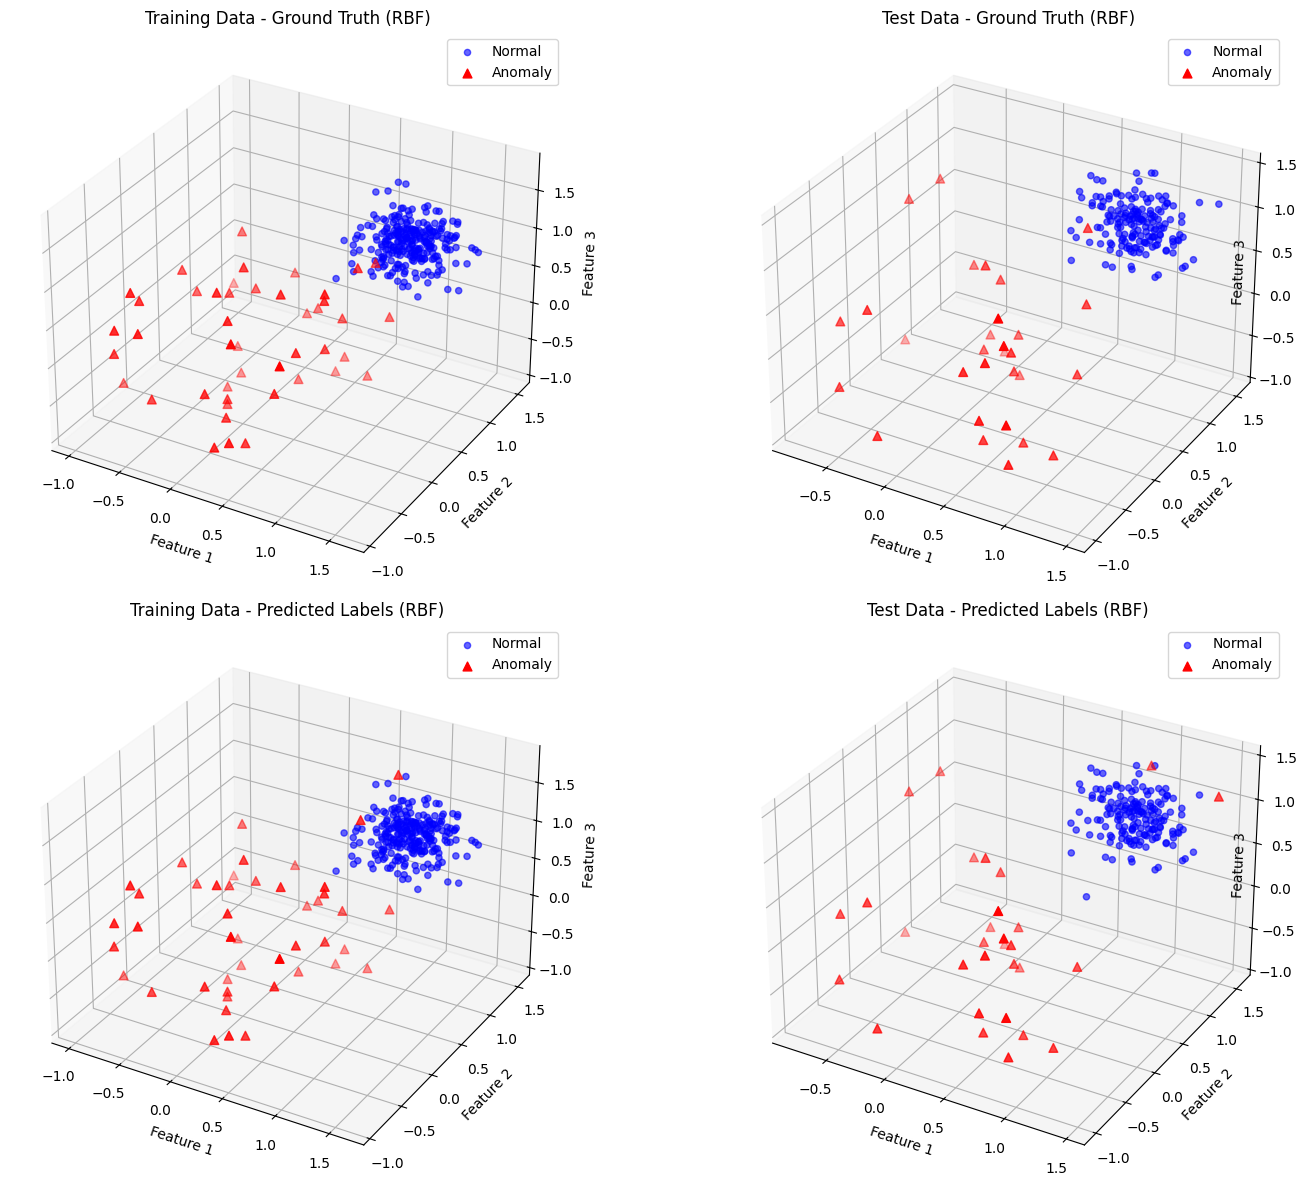

In [5]:
from pyod.models.ocsvm import OCSVM

ocsvm_rbf = OCSVM(kernel='rbf', contamination=0.15)
ocsvm_rbf.fit(X_train)

y_test_pred_rbf = ocsvm_rbf.predict(X_test)
y_test_scores_rbf = ocsvm_rbf.decision_function(X_test)

bacc_rbf = balanced_accuracy_score(y_test, y_test_pred_rbf)
roc_auc_rbf = roc_auc_score(y_test, y_test_scores_rbf)
conf_matrix_rbf = confusion_matrix(y_test, y_test_pred_rbf)

print(f"Balanced Accuracy (RBF): {bacc_rbf:.4f}")
print(f"ROC AUC (RBF):          {roc_auc_rbf:.4f}")
print("\nConfusion Matrix (RBF):")
print(conf_matrix_rbf)

# Create 4 subplots for RBF kernel
fig = plt.figure(figsize=(16, 12))

# First subplot: Training data - Ground Truth
ax1 = fig.add_subplot(221, projection='3d')
plot_3d_subplot(ax1, X_train, y_train, "Training Data - Ground Truth (RBF)")

# Second subplot: Test data - Ground Truth
ax2 = fig.add_subplot(222, projection='3d')
plot_3d_subplot(ax2, X_test, y_test, "Test Data - Ground Truth (RBF)")
ax2.set_zlabel('Feature 3', labelpad=-28, fontsize=10)

# Third subplot: Training data - Predicted Labels
ax3 = fig.add_subplot(223, projection='3d')
plot_3d_subplot(ax3, X_train, ocsvm_rbf.labels_, "Training Data - Predicted Labels (RBF)")

# Fourth subplot: Test data - Predicted Labels
ax4 = fig.add_subplot(224, projection='3d')
plot_3d_subplot(ax4, X_test, y_test_pred_rbf, "Test Data - Predicted Labels (RBF)")
ax4.set_zlabel('Feature 3', labelpad=-28, fontsize=10)

plt.tight_layout()
plt.show()

**Conclusion:**

There is a clear, empty gap between the two groups that can be sliced by a flat plane. 
This is why the Linear Kernel performed so well. It didn't need to curve around the data; it just needed to draw a straight line (or plane) between them.

The RBF kernel adds complexity by trying to fit a curved "envelope" around the data. 
In this specific case, introduced slight overfitting or edge-case errors, leading to 2 false positives instead of 1.


5. Perform steps 2 and 3 for **DeepSVDD** model from **pyod.models.deep_svdd**.

Epoch 50/50, Loss: 2.760058805346489
Balanced Accuracy (DeepSVDD): 0.9245
ROC AUC (DeepSVDD):          0.9539

Confusion Matrix (DeepSVDD):
[[167   3]
 [  4  26]]


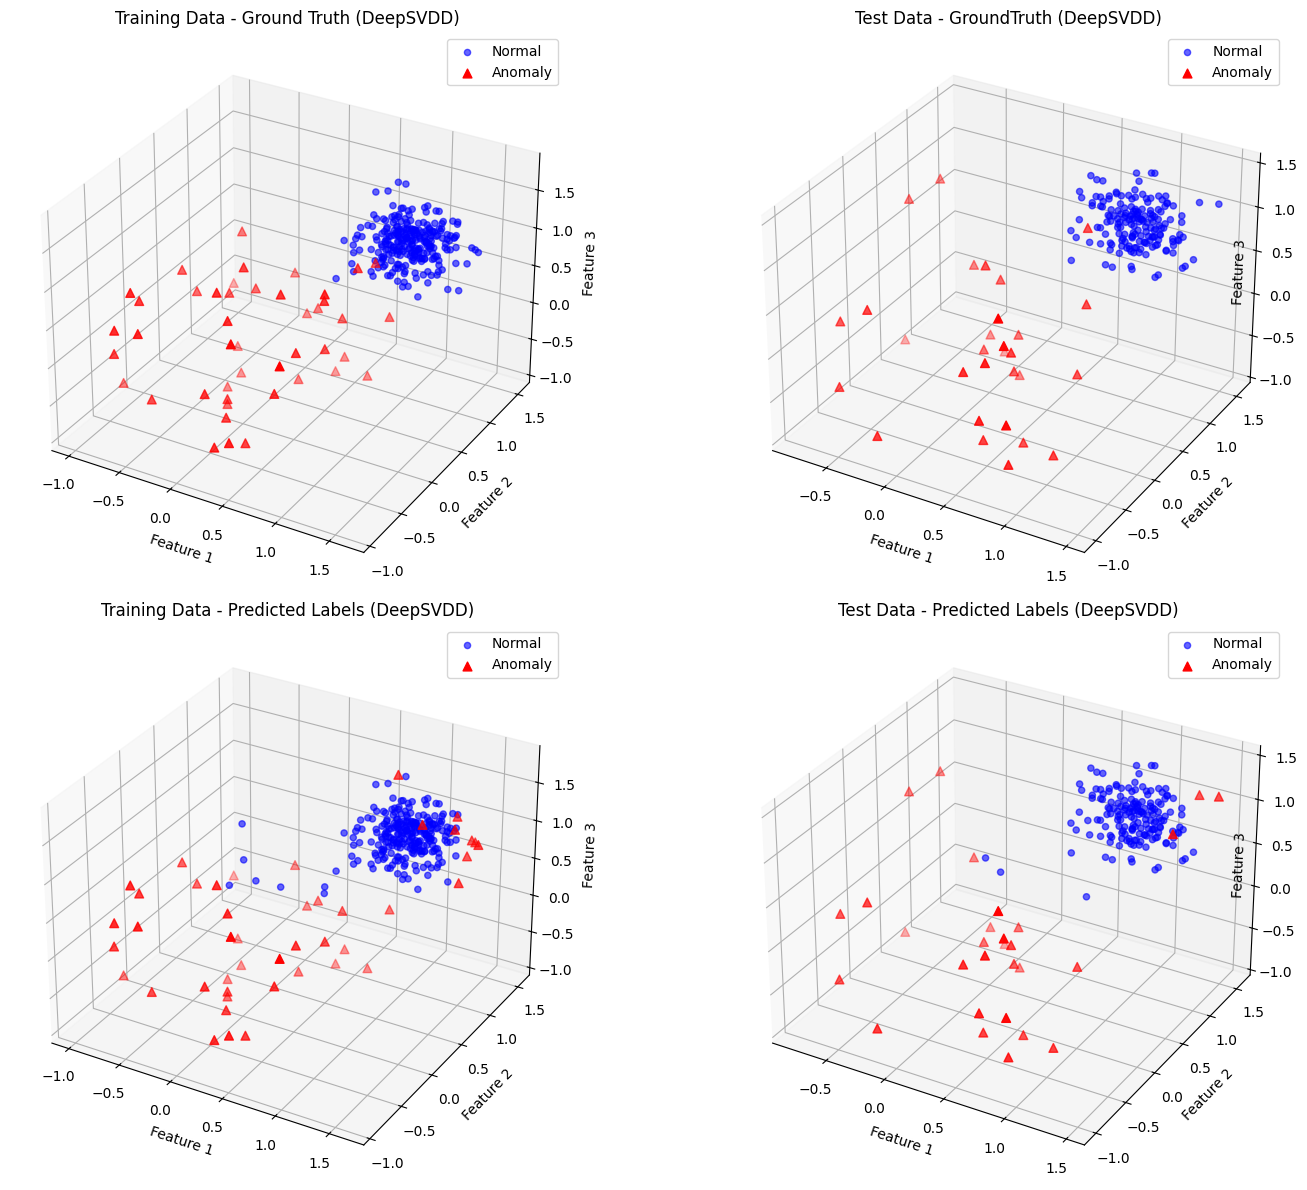

In [6]:
from pyod.models.deep_svdd import DeepSVDD
import contextlib
import io

deep_svdd = DeepSVDD(
    n_features=3, 
    contamination=0.15, 
    hidden_neurons=[32, 16],
    epochs=50, 
    batch_size=32, 
    random_state=34,
    verbose=1
)

buff = io.StringIO()
with contextlib.redirect_stdout(buff):
    deep_svdd.fit(X_train)

last_epoch = buff.getvalue().strip().split('\n')[-1]
print(last_epoch)

y_test_pred_svdd = deep_svdd.predict(X_test)
y_test_scores_svdd = deep_svdd.decision_function(X_test)

bacc_svdd = balanced_accuracy_score(y_test, y_test_pred_svdd)
roc_auc_svdd = roc_auc_score(y_test, y_test_scores_svdd)
conf_matrix_svdd = confusion_matrix(y_test, y_test_pred_svdd)

print(f"Balanced Accuracy (DeepSVDD): {bacc_svdd:.4f}")
print(f"ROC AUC (DeepSVDD):          {roc_auc_svdd:.4f}")
print("\nConfusion Matrix (DeepSVDD):")
print(conf_matrix_svdd)

# Create 4 subplots for DeepSVDD
fig = plt.figure(figsize=(16, 12))

# First subplot: Training data - Ground Truth
ax1 = fig.add_subplot(221, projection='3d')
plot_3d_subplot(ax1, X_train, y_train, "Training Data - Ground Truth (DeepSVDD)")

# Second subplot: Test data - Ground Truth
ax2 = fig.add_subplot(222, projection='3d')
plot_3d_subplot(ax2, X_test, y_test, "Test Data - GroundTruth (DeepSVDD)")
ax2.set_zlabel('Feature 3', labelpad=-28, fontsize=10)

# Third subplot: Training data - Predicted Labels
ax3 = fig.add_subplot(223, projection='3d')
plot_3d_subplot(ax3, X_train, deep_svdd.labels_, "Training Data - Predicted Labels (DeepSVDD)")

# Fourth subplot: Test data - Predicted Labels
ax4 = fig.add_subplot(224, projection='3d')
plot_3d_subplot(ax4, X_test, y_test_pred_svdd, "Test Data - Predicted Labels (DeepSVDD)")
ax4.set_zlabel('Feature 3', labelpad=-28, fontsize=10)

plt.tight_layout()
plt.show()

**Conclusions:**

DeepSVDD underperformed on this task compared to the simpler OCSVM. 

The results illustrate [Occam's Razor](https://en.wikipedia.org/wiki/Occam's_razor) in Data Science: for simple, linearly separable data, simpler models (like Linear OCSVM) are often more accurate, faster, and more robust than complex Deep Learning approaches."

### 2.2 Ex. 2
1. In this exercise, you will use the cardio dataset from [ODDS](https://odds.cs.stonybrook.edu/cardiotocogrpahy-dataset/). 
You will split the dataset into a training set consisting of $40\%$ of the data and a testing set.

In [7]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.io import loadmat
from sklearn.model_selection import train_test_split

data = loadmat('data/cardio.mat') # cardio 1.mat is a duplicate of cardio.mat
X = data['X']
y = data['y'].ravel()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.4, random_state=42, stratify=y
)

print(f"Original Feature Count: {X.shape[1]}")
print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

Original Feature Count: 21
Training set size: (732, 21)
Test set size: (1099, 21)


2. You will use cross-validation grid-search over a predefined map of posible parameters of **OneClassSVM** (from **sklearn.svm**) in order to find the ones that offer best results. The map of possible parameters must contain different kernels, different value for the $\nu$ parameter (including the contamination rate of train set).

In [8]:
import numpy as np

from sklearn.svm import OneClassSVM 
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

contamination_rate = np.sum(y_train == 1) / len(y_train)
print(f"Contamination Rate: {contamination_rate:.4f}")

param_grid = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'nu': [0.01, 0.05, contamination_rate, 0.1, 0.15, 0.2, 0.25],
    'gamma': ['scale', 'auto', 0.1, 0.2, 0.25, 0.3, 0.5]
}

best_auc = -1
best_params = {}

# Ensure every fold has some outliers
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for kernel in param_grid['kernel']:
    for nu in param_grid['nu']:
        for gamma in param_grid['gamma']:
            fold_auc_scores = []
            for train_index, val_index in skf.split(X_train, y_train):
                # Create the folds
                X_fold_train, X_fold_val = X_train[train_index], X_train[val_index]

                # Initialize and fit the model
                clf = OneClassSVM(kernel=kernel, nu=nu, gamma=gamma)
                clf.fit(X_fold_train)

                # Score on validation fold
                scores = clf.decision_function(X_fold_val)
                y_fold_true = y_train[val_index]

                # Negate scores so Outliers (1) have higher values than Normal (0)
                auc = roc_auc_score(y_fold_true, -scores)
                fold_auc_scores.append(auc)

            avg_auc = np.mean(fold_auc_scores) 
            if avg_auc > best_auc:
                best_auc = avg_auc
                best_params = {'kernel': kernel, 'nu': nu, 'gamma': gamma}

print("-" * 30)
print(f"Best Validation AUC: {best_auc:.4f}")
print(f"Best Parameters: {best_params}")

Contamination Rate: 0.0956
------------------------------
Best Validation AUC: 0.9009
Best Parameters: {'kernel': 'rbf', 'nu': 0.25, 'gamma': 'scale'}


3. **GridSearchCV** from **sklearn.model_selection** will be used to perform the grid-search over the training set using Balanced Accuracy as score. the same metric will be reported for the model trained with the best parameters discovered by **GridSearchCV** (tessted on the test set).

In [9]:
from sklearn.metrics import make_scorer
from sklearn.svm import OneClassSVM 
from sklearn.model_selection import GridSearchCV, StratifiedKFold

def custom_balanced_accuracy(y_true, y_pred):
    # OneClassSVM outputs: 1 (Normal), -1 (Outlier)
    # y_true has: 0 (Normal), 1 (Outlier)
    # y_pred_converted = np.where(y_pred == -1, 1, 0)
    y_pred_converted = (-1 * y_pred + 1) / 2
    return balanced_accuracy_score(y_true, y_pred_converted)

bacc_scorer = make_scorer(custom_balanced_accuracy)
cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

osvm = OneClassSVM()
grid_search = GridSearchCV(
    estimator=osvm, 
    param_grid=param_grid,
    scoring=bacc_scorer, 
    cv=cv_strategy, 
    n_jobs=-1, 
    verbose=0
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")
print(f"Best CV Balanced Accuracy: {grid_search.best_score_:.4f}")

best_ocsvm = grid_search.best_estimator_

# Get raw predictions
y_test_pred_raw = best_ocsvm.predict(X_test) # Returns 1 / -1
y_test_scores = best_ocsvm.decision_function(X_test) # Returns scores

# SAME LOGIC AS SCORER
# y_test_pred_converted = np.where(y_test_pred_raw == -1, 1, 0)
y_test_pred_converted = (-1 * y_test_pred_raw + 1) / 2
bacc = balanced_accuracy_score(y_test, y_test_pred_converted)
roc_auc = roc_auc_score(y_test, -y_test_scores) 

print(f"Balanced Accuracy on test set: {bacc:.4f}")
print(f"ROC AUC on test set: {roc_auc:.4f}")

Best parameters: {'gamma': 'auto', 'kernel': 'rbf', 'nu': 0.25}
Best CV Balanced Accuracy: 0.8434
Balanced Accuracy on test set: 0.8601
ROC AUC on test set: 0.9062


4. **GridSearchCV** will have to perform standardization; for this; it will use **Pipeline** from **sklearn.pipeline** that will perform standardization using **StandardScaler** before the **OneClassSVM** model.

5. You have to pay attention to the labels returned by **OneClassSVM** model (from **sklearn**): -1 outliers and 1 for inliers. If you want to convert
them to the pyod format you can use:
$$
\text{label\_pyod} = \frac{-1 \times \text{label\_sklearn} + 1}{2}
$$

6. Print the best parameters discovered by **GridSearchCV** and the balanced accuracy obtained by the model (trained with those parameters on
the entire training dataset) when evaluating the testing set.

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('clf', OneClassSVM())
])

param_grid_pipe = {
    'clf__kernel': param_grid['kernel'],
    'clf__nu': param_grid['nu'],
    'clf__gamma': param_grid['gamma']
}

grid_search_pipe = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid_pipe,
    scoring=bacc_scorer,
    cv=cv_strategy,
    n_jobs=-1,
    verbose=1
)

grid_search_pipe.fit(X_train, y_train)

print("-" * 30)
print(f"Best parameters (pipeline): {grid_search_pipe.best_params_}")
print(f"Best CV Balanced Accuracy (pipeline): {grid_search_pipe.best_score_:.4f}")

best_pipe = grid_search_pipe.best_estimator_

y_test_pred_raw = best_pipe.predict(X_test)  # 1 (normal) / -1 (outlier)
y_test_scores = best_pipe.decision_function(X_test)

y_test_pred_pyod = (-1 * y_test_pred_raw + 1) / 2
bacc_test = balanced_accuracy_score(y_test, y_test_pred_pyod)
roc_auc_test = roc_auc_score(y_test, -y_test_scores)

print(f"Balanced Accuracy on test set (pipeline): {bacc_test:.4f}")
print(f"ROC AUC on test set (pipeline): {roc_auc_test:.4f}")

Fitting 3 folds for each of 196 candidates, totalling 588 fits
------------------------------
Best parameters (pipeline): {'clf__gamma': 'scale', 'clf__kernel': 'rbf', 'clf__nu': 0.25}
Best CV Balanced Accuracy (pipeline): 0.8411
Balanced Accuracy on test set (pipeline): 0.8596
ROC AUC on test set (pipeline): 0.9050


### 2.3 Ex. 3
1. For this exercise we will need to download the shuttle dataset from [ODDS](https://odds.cs.stonybrook.edu/shuttle-dataset/). Load the dataset using **scipy.io.loadmat()** and use **train_test_split()** to split into train and test subsets (use $50\%$ of the data for testing). Normalize your data accordingly.

In [11]:
data_shuttle = loadmat('data/shuttle.mat')
shuttle_X = data_shuttle['X']
shuttle_y = data_shuttle['y'].ravel()

print(f"Binary Distribution (0/1): {np.bincount(shuttle_y)}")

shuttle_X_train, shuttle_X_test, shuttle_y_train, shuttle_y_test = train_test_split(
    shuttle_X, shuttle_y, 
    test_size=0.5, 
    random_state=42, 
    stratify=shuttle_y
)

print(f"Train shape: {shuttle_X_train.shape}, Test shape: {shuttle_X_test.shape}")

scaler = StandardScaler()
shuttle_X_train_scaled = scaler.fit_transform(shuttle_X_train)
shuttle_X_test_scaled = scaler.transform(shuttle_X_test)

contamination_train = np.mean(shuttle_y_train == 1)
contamination_test = np.mean(shuttle_y_test == 1)

print("-" * 30)
print(f"Number of Features: {shuttle_X.shape[1]}")
print(f"Training Contamination (Outlier rate): {contamination_train:.2%}")
print(f"Testing Contamination (Outlier rate):  {contamination_test:.2%}")

Binary Distribution (0/1): [45586  3511]
Train shape: (24548, 9), Test shape: (24549, 9)
------------------------------
Number of Features: 9
Training Contamination (Outlier rate): 7.15%
Testing Contamination (Outlier rate):  7.15%


2. Fit **OCSVM** and **DeepSVDD** models **(from pyod)** using the training data and compute the balanced accuracy **(BA)** and the area under the curve for the testing data for both models (**ROC AUC** - using **sklearn.metrics.roc_auc_score**).

In [12]:
ocsvm_shuttle = pyod.models.ocsvm.OCSVM(kernel='rbf', contamination=contamination_train)
ocsvm_shuttle.fit(shuttle_X_train_scaled)

y_test_pred_ocsvm = ocsvm_shuttle.predict(shuttle_X_test_scaled) # inlier, 1 = outlier
y_test_scores_ocsvm = ocsvm_shuttle.decision_function(shuttle_X_test_scaled)

ba_ocsvm = balanced_accuracy_score(shuttle_y_test, y_test_pred_ocsvm)
roc_ocsvm = roc_auc_score(shuttle_y_test, y_test_scores_ocsvm)

print(f"OCSVM (pyod) - Balanced Accuracy: {ba_ocsvm:.4f}, ROC AUC: {roc_ocsvm:.4f}")


# Fit DeepSVDD (pyod) on scaled shuttle data
deep_svdd_shuttle = DeepSVDD(
    n_features=shuttle_X_train_scaled.shape[1],
    contamination=contamination_train,
    hidden_neurons=[64, 32],
    epochs=50,
    batch_size=256,
    random_state=42,
    verbose=1
)

# suppress verbose training output
buff = io.StringIO()
with contextlib.redirect_stdout(buff):
    deep_svdd_shuttle.fit(shuttle_X_train_scaled)

print("Loss DEEPSVDD shuttle last epoch:", buff.getvalue().strip().split('\n')[-1])

y_test_pred_svdd = deep_svdd_shuttle.predict(shuttle_X_test_scaled)    # 0 = inlier, 1 = outlier
y_test_scores_svdd = deep_svdd_shuttle.decision_function(shuttle_X_test_scaled)

ba_svdd = balanced_accuracy_score(shuttle_y_test, y_test_pred_svdd)
roc_svdd = roc_auc_score(shuttle_y_test, y_test_scores_svdd)

print(f"DeepSVDD (pyod) - Balanced Accuracy: {ba_svdd:.4f}, ROC AUC: {roc_svdd:.4f}")

OCSVM (pyod) - Balanced Accuracy: 0.9747, ROC AUC: 0.9914
Loss DEEPSVDD shuttle last epoch: Epoch 50/50, Loss: 68.6155546605587
DeepSVDD (pyod) - Balanced Accuracy: 0.9617, ROC AUC: 0.9918


3. Use different architectures for **DeepSVDD** and compute the 2 aforementioned metrics for each case.

In [19]:
architectures = [
    [32, 16],
    [64, 32],
    [128, 64],
    [128, 64, 32],
    [64, 32, 16]
]

results_list = []

print(f"{'Architecture':<20} | {'Balanced Accuracy':<18} | {'ROC AUC':<10}")
print("-" * 55)

for arch in architectures:
    # create model with given architecture, quieter training (verbose=0)
    arch_str = str(arch)

    model = DeepSVDD(
        n_features=shuttle_X_train_scaled.shape[1],
        contamination=contamination_train,
        hidden_neurons=arch,
        epochs=50,
        batch_size=256,
        random_state=42,
        verbose=0
    )

    # Suppress stdout
    with contextlib.redirect_stdout(io.StringIO()):
        model.fit(shuttle_X_train_scaled)

    # Predict
    y_pred = model.predict(shuttle_X_test_scaled)
    y_scores = model.decision_function(shuttle_X_test_scaled)

    # Metrics
    ba = balanced_accuracy_score(shuttle_y_test, y_pred)
    auc = roc_auc_score(shuttle_y_test, y_scores)

    results_list.append({
        'Architecture': arch_str,
        'Balanced Acc': ba,
        'ROC AUC': auc
    })
    
    print(f"{arch_str:<20} | {ba:.4f}             | {auc:.4f}")

Architecture         | Balanced Accuracy  | ROC AUC   
-------------------------------------------------------
[32, 16]             | 0.8914             | 0.9867
[64, 32]             | 0.9617             | 0.9918
[128, 64]            | 0.9714             | 0.9901
[128, 64, 32]        | 0.9715             | 0.9895
[64, 32, 16]         | 0.8530             | 0.9799
